### SINDy-SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**. 

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **weekly mean sea-surface temperature (SST) dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe the SST evolution.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset

import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sindy
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
num_sensors = 250
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

(1400, 64800)


We now select indices to divide the data into training, validation, and test sets.

Set random seed

In [2]:
import random
import numpy as np
import torch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [3]:
train_indices = np.arange(0,1000)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[:30]
test_indices = valid_test_indices[30:]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [5]:
len(test_dataset)

318

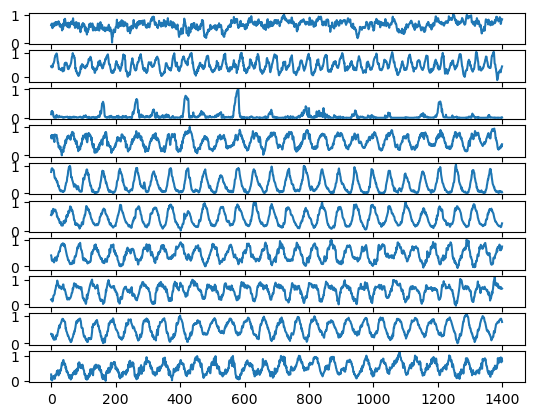

In [6]:
sub_index_X = transformed_X[:,sensor_locations]
fig, ax = plt.subplots(10)

for i in range(10):
    ax[i].plot(sub_index_X[:,i])

We set up SINDy library coefficients

In [7]:
latent_dim = 3
poly_order = 3
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

We train the model using the training and validation datasets.

In [8]:
import sindy_shred
shred = sindy_shred.SINDy_SHRED(num_sensors, m, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1, 
                                 library_dim=library_dim, poly_order=poly_order, include_sine=include_sine, dt=1/52.0*0.1, layer_norm=False).to(device)
validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=600, lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0, optimizer="Lion", thres_epoch=100)

1 : tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0221, device='cuda:

134 : tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
135 : tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
136 : tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)
137 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
138 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
139 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
140 : tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)
141 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
142 : tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)
143 : tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
144 : tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
145 : tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
146 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
147 : tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)
148 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
149 : tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)
150 : te

266 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
267 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
268 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
269 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
270 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
271 : tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)
272 : tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)
273 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
274 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
275 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
276 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
277 : tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)
278 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
279 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
280 : tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
281 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
282 : te

398 : tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
399 : tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
400 : tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)
Training epoch 400
Error tensor(0.2239, device='cuda:0')
401 : tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)
402 : tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
403 : tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
404 : tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
405 : tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
406 : tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
407 : tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
408 : tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)
409 : tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)
410 : tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
411 : tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>)
412 : tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)
413 : tensor(

529 : tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)
530 : tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)
531 : tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)
532 : tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)
533 : tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>)
534 : tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)
535 : tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)
536 : tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)
537 : tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)
538 : tensor(0.0088, device='cuda:0', grad_fn=<AddBackward0>)
539 : tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)
540 : tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)
541 : tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)
542 : tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>)
543 : tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)
544 : tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)
545 : te

In [9]:
# Rate of sparsity
torch.mean(shred.e_sindy.coefficient_mask*1.0)

tensor(0.7617, device='cuda:0')

We then generate reconstructions from the test set and print mean square error compared to the ground truth.

In [10]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.043652117


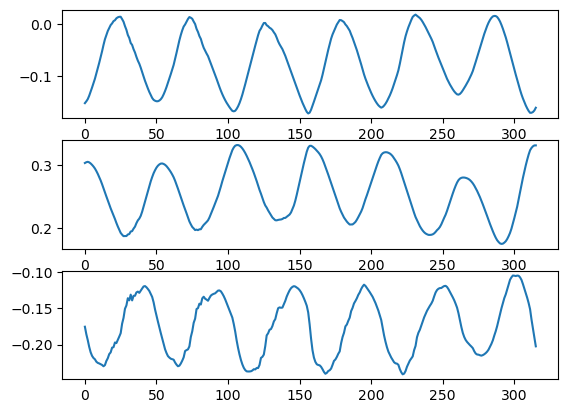

In [11]:
import pysindy as ps
from pysindy.differentiation import FiniteDifference
gru_outs, sindy_outs = shred.gru_outputs(test_dataset.X, sindy=True)
differentiation_method = FiniteDifference()

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())

In [12]:
import gurobipy as gp  # import the installed package
params = {
"WLSACCESSID": '3cb79fce-3a73-4391-8eb8-ad19d8bd0912',
"WLSSECRET": '219e58c5-11b4-4f90-b067-249d35332092',
"LICENSEID": 2526320,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2526320
Academic license 2526320 - for non-commercial use only - registered to ma___@uw.edu


In [13]:
import time

import gurobipy as gp
import numpy as np
import pysindy as ps
from pysindy.optimizers.base import BaseOptimizer
from scipy.integrate import odeint
from sklearn.utils.validation import check_is_fitted


class MIOSR(BaseOptimizer):
    """
    Parameters
    ----------
    alpha : float, optional (default 0.05)
        Optional L2 (ridge) regularization on the weight vector.
    fit_intercept : boolean, optional (default False)
        Whether to calculate the intercept for this model. If set to false, no
        intercept will be used in calculations.
    normalize : boolean, optional (default False)
        This parameter is ignored when fit_intercept is set to False. If True,
        the regressors X will be normalized before regression by subtracting
        the mean and dividing by the l2-norm.
    copy_X : boolean, optional (default True)
        If True, X will be copied; else, it may be overwritten.
    initial_guess : np.ndarray, shape (n_features) or (n_targets, n_features), \
            optional (default None)
        Initial guess for coefficients ``coef_``.
        If None, least-squares is used to obtain an initial guess.
    Attributes
    ----------
    coef_ : array, shape (n_features,) or (n_targets, n_features)
        Weight vector(s).
    ind_ : array, shape (n_features,) or (n_targets, n_features)
        Array of 0s and 1s indicating which coefficients of the
        weight vector have not been masked out, i.e. the support of
        ``self.coef_``.
    history_ : list
        History of ``coef_``. ``history_[k]`` contains the values of
        ``coef_`` at iteration k of sequentially thresholded least-squares.
    """

    def __init__(
            self,
            target_sparsity=None,
            group_sparsity=None,
            constraint_lhs=None,
            constraint_rhs=None,
            constraint_order="target",
            alpha=0.05,
            regression_timeout=30,
            normalize_columns=False,
            fit_intercept=False,
            copy_X=True,
            initial_guess=None,
            verbose=False
    ):
        super(MIOSR, self).__init__(
            normalize_columns=normalize_columns,
            fit_intercept=fit_intercept,
            copy_X=copy_X,
        )

        if target_sparsity is not None and\
                    (target_sparsity <= 0 or not isinstance(target_sparsity, int)):
            raise ValueError("target_sparsity must be positive int")
        if constraint_order not in {"target", "feature"}:
            raise ValueError("constraint_order must be one of {'target', 'feature'}")
        if alpha < 0:
            raise ValueError("alpha cannot be negative")

        self.target_sparsity = target_sparsity
        self.group_sparsity = group_sparsity
        self.constraint_lhs = constraint_lhs
        self.constraint_rhs = constraint_rhs
        self.constraint_order = constraint_order
        self.lambda_2 = alpha
        self.initial_guess = initial_guess
        self.regression_timeout = regression_timeout
        self.verbose = verbose

        # Regression model class variables used for model selection
        self._model_made = False
        self._model = None
        self._beta_vars = None
        self._is_zero_vars = None
        self.solve_times = []
        self.build_times = []

    def _make_model(self, X, y, k, warm_start=None):
        m = gp.Model(env=env)
        n, d = X.shape
        _, r = y.shape

        beta = m.addMVar(r * d, lb=-gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="beta")
        iszero = m.addMVar(r * d, vtype=gp.GRB.BINARY, name="iszero")

        # Sparsity constraint
        for i in range(r * d):
            m.addSOS(gp.GRB.SOS_TYPE1, [beta[i], iszero[i]])
        m.addConstr(iszero.sum() >= (r * d) - k, name="sparsity")

        # Group sparsity constraints
        if self.target_sparsity is not None and self.group_sparsity is not None:
            for i in range(r):
                group_cardinality = self.group_sparsity[i]
                print(group_cardinality)
                m.addConstr(iszero[i*d: (i+1)*d].sum() == d - group_cardinality, name=f"group_sparsity{i}")

        # General equality constraints
        if self.constraint_lhs is not None and self.constraint_rhs is not None:
            if self.constraint_order == "feature":
                target_indexing = np.arange(r * d).reshape(r, d, order='F').flatten()
                constraint_lhs = self.constraint_lhs[:, target_indexing]
            else:
                constraint_lhs = self.constraint_lhs
            m.addConstr(constraint_lhs @ beta == self.constraint_rhs, name='coefficient_constrs')

        if warm_start is not None:
            warm_start = warm_start.reshape(1, r*d)[0]
            for i in range(d):
                iszero[i].start = (abs(warm_start[i]) < 1e-6)
                beta[i].start = warm_start[i]

        Quad = np.dot(X.T, X)
        obj = self.lambda_2 * (beta @ beta)
        for i in range(r):
            lin = np.dot(y[:, i].T, X)
            obj += beta[d * i: d * (i + 1)] @ Quad @ beta[d * i: d * (i + 1)]
            obj -= 2 * (lin @ beta[d * i: d * (i + 1)])

        m.setObjective(obj, gp.GRB.MINIMIZE)

        m.params.OutputFlag = 1 if self.verbose else 0
        m.params.timelimit = self.regression_timeout
        m.update()

        self._model_made = True
        self._model = m
        self._beta_vars = beta
        self._is_zero_vars = iszero

    def _change_sparsity(self, new_k):
        sparsity_constr = self._model.getConstrByName('sparsity')
        sparsity_constr.rhs = self._beta_vars.shape[0] - new_k
        self._model.update()
        self.target_sparsity = new_k

    def _change_regularizer(self, new_lambda2):
        coef_change = new_lambda2 - self.lambda_2
        regularizer = gp.quicksum(self._beta_vars[i] ** 2
                                  for i in range(self._beta_vars.shape[0]))
        new_obj = self._model.getObjective() + coef_change * regularizer
        self._model.setObjective(new_obj)
        self._model.update()
        self.lambda_2 = new_lambda2

    def _regress(self, X, y, k, warm_start=None):
        """
        Deploy and optimize the MIQP formulation of L0-Regression.
        """
        model_construction_start_t = time.time()
        self._make_model(X, y, k, warm_start)
        self.build_times.append(time.time() - model_construction_start_t)
        solve_start_t = time.time()
        self._model.optimize()
        self.solve_times.append(time.time() - solve_start_t)
        return self._beta_vars.X

    def _reduce(self, x, y):
        """Performs at most ``self.max_iter`` iterations of the
        sequentially-thresholded least squares algorithm.
        Assumes an initial guess for coefficients and support are saved in
        ``self.coef_`` and ``self.ind_``.
        """
        regress_jointly = self.target_sparsity is not None

        if self.initial_guess is not None:
            self.coef_ = self.initial_guess

        n, d = x.shape
        n, r = y.shape

        if regress_jointly:
            coefs = self._regress(x, y, self.target_sparsity)
            non_active_ixs = np.argsort(np.abs(coefs))[:-int(self.target_sparsity)]
            coefs[non_active_ixs] = 0
            self.coef_ = coefs.reshape(r, d)
            self.ind_ = (np.abs(self.coef_) > 1e-6).astype(int)
        else:
            for i in range(r):
                k = self.group_sparsity[i]
                warm_start = None if self.initial_guess is None else self.initial_guess[[i], :]
                coef_i = self._regress(x, y[:, [i]], k, warm_start=warm_start)
                # Remove nonzero terms due to numerical error
                non_active_ixs = np.argsort(np.abs(coef_i))[:-int(k)]
                coef_i[non_active_ixs] = 0
                self.coef_[i, :] = coef_i
            self.ind_ = (np.abs(self.coef_) > 1e-6).astype(int)

    @property
    def complexity(self):
        check_is_fitted(self)
        return np.count_nonzero(self.coef_)


if __name__ == "__main__":
    # Generate training data

    def lorenz(x, t):
        return [
            10 * (x[1] - x[0]),
            x[0] * (28 - x[2]) - x[1],
            x[0] * x[1] - 8 / 3 * x[2],
        ]

    dt = 0.001
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    x_train = odeint(lorenz, x0_train, t_train)
    x_dot_train_measured = np.array(
        [lorenz(x_train[i], 0) for i in range(t_train.size)]
    )
    # Fit the model
    poly_order = 2
    threshold = 0.05
    model = ps.SINDy(
        optimizer=MIOSR(
            group_sparsity=(2, 3, 2),
            alpha=0.05,
        ),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(x_train,
              t=dt,
              x_dot=x_dot_train_measured,
              unbias=False)
    model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


(x0)' = -1.568 x0 + -6.400 x2
(x1)' = -2.005 x0 + 4.262 x2
(x2)' = 6.261 x0 + 1.581 x2


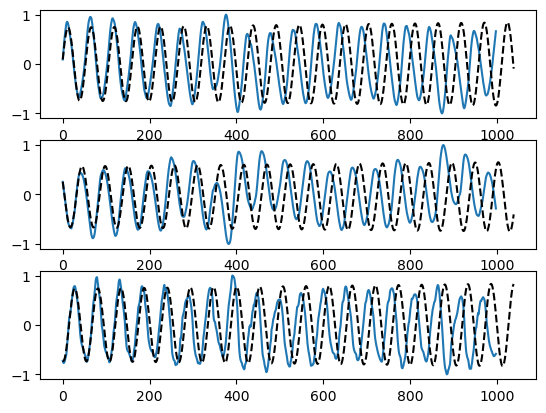

In [14]:
gru_outs, sindy_outs = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs = gru_outs[:,0,:]

poly_order = 2
threshold = 0.05

# gru_outs = (gru_outs - torch.mean(gru_outs, axis=0)) / torch.std(gru_outs, axis=0)

gru_outs[:,0] = (gru_outs[:,0] - torch.min(gru_outs[:,0])) / (torch.max(gru_outs[:,0])-torch.min(gru_outs[:,0]))
gru_outs[:,1] = (gru_outs[:,1] - torch.min(gru_outs[:,1])) / (torch.max(gru_outs[:,1])-torch.min(gru_outs[:,1]))
gru_outs[:,2] = (gru_outs[:,2] - torch.min(gru_outs[:,2])) / (torch.max(gru_outs[:,2])-torch.min(gru_outs[:,2]))

gru_outs = 2 * gru_outs - 1

# gru_outs = gru_outs[500:]

x = gru_outs.detach().cpu().numpy()

differentiation_method = ps.differentiation.FiniteDifference()
# differentiation_method = ps.differentiation.SmoothedFiniteDifference()

# model = ps.SINDy(
#     optimizer=ps.STLSQ(threshold=0, alpha=0.05),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order)
# )

# model = ps.SINDy(
#     optimizer=MIOSR(target_sparsity=10, alpha=50),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order)+ps.FourierLibrary(include_cos=False),
# )
model = ps.SINDy(
    optimizer=MIOSR(group_sparsity=(2,2,2), alpha=0.05),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x, t=1/52.0, ensemble=False)
model.print()

t_train = np.arange(0, 20, 1/52.0)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy())
    ax[i].plot(x_sim[:,i], "k--", label="model")

In [15]:
gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:,0,:]
gru_outs_val, _ = shred.gru_outputs(valid_dataset.X, sindy=True)
gru_outs_val = gru_outs_val[:,0,:]
gru_outs_test, _ = shred.gru_outputs(test_dataset.X, sindy=True)
gru_outs_test = gru_outs_test[:,0,:]

In [16]:
gru_outs_all = np.zeros((1345, 3))
gru_outs_all[:999,:] = gru_outs_train.detach().cpu().numpy()
gru_outs_all[999:1028,:] = gru_outs_val.detach().cpu().numpy()
gru_outs_all[1028:,:] = gru_outs_test.detach().cpu().numpy()

gru_outs_numpy = gru_outs_train.detach().cpu().numpy()

gru_outs_all[:,0] = (gru_outs_all[:,0] - np.min(gru_outs_numpy[:,0])) / (np.max(gru_outs_numpy[:,0])-np.min(gru_outs_numpy[:,0]))
gru_outs_all[:,1] = (gru_outs_all[:,1] - np.min(gru_outs_numpy[:,1])) / (np.max(gru_outs_numpy[:,1])-np.min(gru_outs_numpy[:,1]))
gru_outs_all[:,2] = (gru_outs_all[:,2] - np.min(gru_outs_numpy[:,2])) / (np.max(gru_outs_numpy[:,2])-np.min(gru_outs_numpy[:,2]))

gru_outs_all = 2 * gru_outs_all - 1

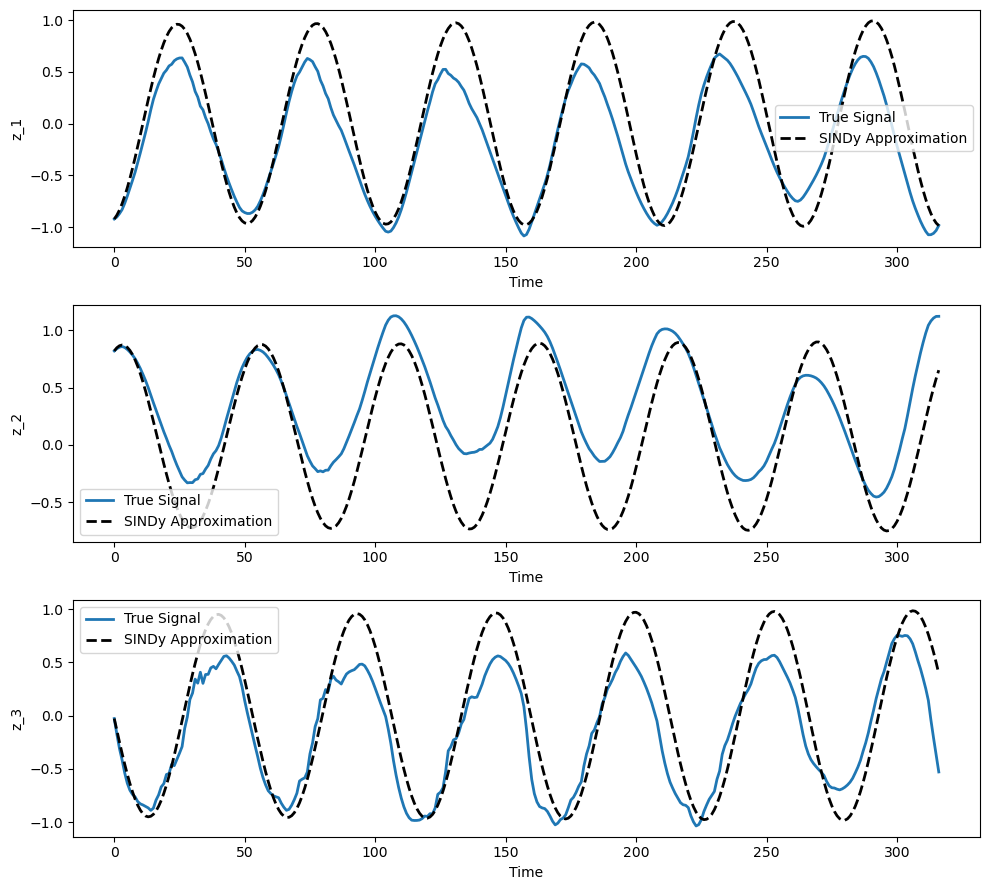

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Normalize the gru_outs_test
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

gru_outs_test_np[:, 0] = (gru_outs_test_np[:, 0] - np.min(gru_outs_numpy[:, 0])) / (np.max(gru_outs_numpy[:, 0]) - np.min(gru_outs_numpy[:, 0]))
gru_outs_test_np[:, 1] = (gru_outs_test_np[:, 1] - np.min(gru_outs_numpy[:, 1])) / (np.max(gru_outs_numpy[:, 1]) - np.min(gru_outs_numpy[:, 1]))
gru_outs_test_np[:, 2] = (gru_outs_test_np[:, 2] - np.min(gru_outs_numpy[:, 2])) / (np.max(gru_outs_numpy[:, 2]) - np.min(gru_outs_numpy[:, 2]))

gru_outs_test_np = 2 * gru_outs_test_np - 1  # Transform to [-1, 1]

# Set up initial condition and simulate with the SINDy model
t_train = np.arange(0, 317*1/52.0, 1/52.0)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs_test_np[0, :]
x_sim_test = model.simulate(init_cond, t_train)

# Plotting for each latent dimension: True vs SINDy
fig, ax = plt.subplots(latent_dim, figsize=(10, latent_dim * 3))

for i in range(latent_dim):
    ax[i].plot(gru_outs_test_np[:, i], label='True Signal', linewidth=2)
    ax[i].plot(x_sim_test[:, i], "k--", label='SINDy Approximation', linewidth=2)
    ax[i].legend()
    ax[i].set_ylabel(f'z_{i+1}')
    ax[i].set_xlabel('Time')

plt.tight_layout()
plt.show()

# Step 1: Revert the normalization to original scale
gru_outs_test_np = (gru_outs_test_np + 1) / 2  # Revert from [-1, 1] to [0, 1]

for i in range(3):  # Assuming 3 latent dimensions for this example
    gru_outs_test_np[:, i] = gru_outs_test_np[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

# Step 2: Decoder reconstruction using the decoder model

# Convert latent space data back to tensor for decoder reconstruction
latent_pred = torch.FloatTensor(gru_outs_test_np).cuda()

# Pass through the decoder (as per your decoder architecture)
output = shred.linear1(latent_pred)
output = shred.dropout(output)
output = torch.nn.functional.relu(output)
output = shred.linear2(output)
output = shred.dropout(output)
output = torch.nn.functional.relu(output)
output = shred.linear3(output)

# Detach and convert to numpy for visualization
output_np = output.detach().cpu().numpy()

# Step 3: Load the original SST data to get the SST grid locations
load_X = loadmat('Data/SST_data.mat')['Z'].T

# Compute the mean across the second axis (columns)
mean_X = np.mean(load_X, axis=0)

# Find the locations where the mean is not zero (SST locations)
sst_locs = np.where(mean_X != 0)[0]

# Step 4: Prepare for visualization of the SST data
# Initialize an empty array with the same shape as the original data
reconstructed_data = np.zeros_like(load_X[0, :])

# Copy the reconstructed values back to the SST locations
reconstructed_data[sst_locs] = output_np[0, :]  # Assuming first timestep

# Step 5: Reshape the data back to 2D (180, 360) for visualization
reshaped_reconstructed = reconstructed_data.reshape(180, 360)

(317, 44219)
(1400, 64800)
41.352707


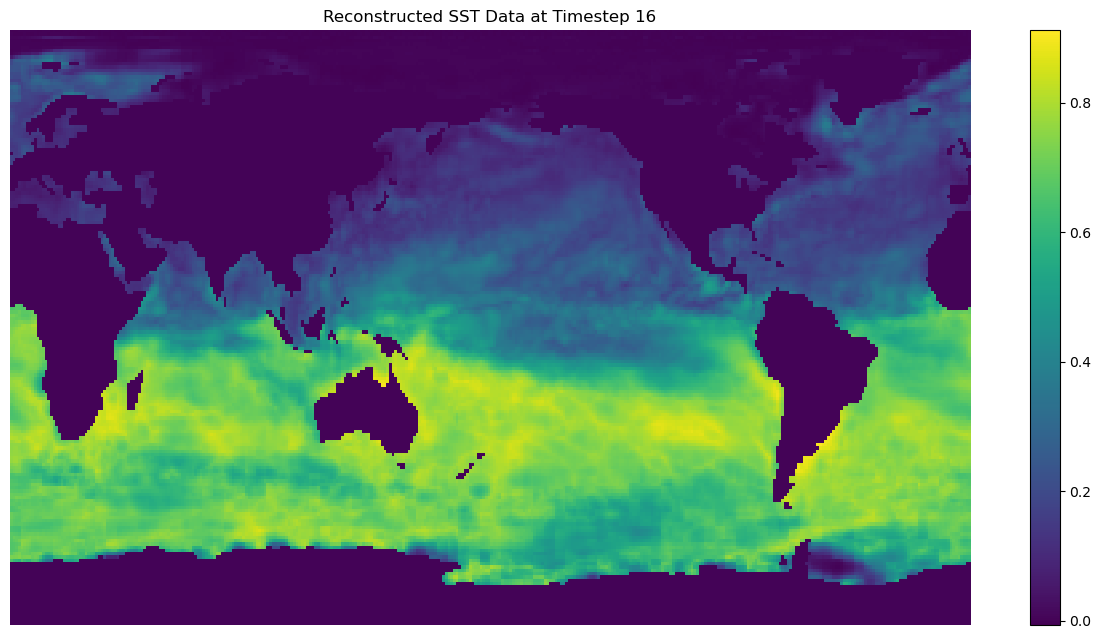

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

def reconstruct_and_plot_sindy(x_sim_test, gru_outs_numpy, decoder_model, sst_data_path, timesteps):
    """
    Reconstructs and visualizes data using SINDy-simulated latent space for multiple timesteps.
    
    Args:
        x_sim_test (np.array): SINDy-simulated latent space.
        gru_outs_numpy (np.array): The original latent space for Min-Max scaling reversal.
        decoder_model (nn.Module): The decoder model for reconstruction.
        sst_data_path (str): Path to the SST data file.
        timesteps (list of int): List of timesteps to plot.

    Returns:
        None. It generates and shows the plots.
    """
    # Step 1: Reverse Min-Max scaling for SINDy-simulated data (x_sim_test)
    x_sim_test = np.array(x_sim_test)  # Ensure it's a numpy array if needed

    # Revert the scaling from [-1, 1] back to [0, 1]
    x_sim_test = (x_sim_test + 1) / 2  

    # Perform the Min-Max reverse transformation using the original min/max values
    for i in range(3):  # Assuming 3 latent dimensions
        x_sim_test[:, i] = x_sim_test[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Step 2: Perform the decoder reconstruction using the transformed SINDy-simulated data
    latent_pred_sindy = torch.FloatTensor(x_sim_test).cuda()  # Convert to torch tensor for reconstruction

    # Pass the SINDy-simulated latent space data through the decoder
    output_sindy = decoder_model.linear1(latent_pred_sindy)
    output_sindy = decoder_model.dropout(output_sindy)
    output_sindy = torch.nn.functional.relu(output_sindy)
    output_sindy = decoder_model.linear2(output_sindy)
    output_sindy = decoder_model.dropout(output_sindy)
    output_sindy = torch.nn.functional.relu(output_sindy)
    output_sindy = decoder_model.linear3(output_sindy)

    # Detach and convert the reconstructed data back to numpy for visualization
    output_sindy_np = output_sindy.detach().cpu().numpy()
#     output_sindy_np = sc.inverse_transform(output_sindy_np)
    print(output_sindy_np.shape)
    
    # Step 3: Load the original SST data to get the SST grid locations
    load_X = loadmat(sst_data_path)['Z'].T
    print(load_X.shape)  # Check the shape of the SST data

    # Compute the mean across the second axis (columns)
    mean_X = np.mean(load_X, axis=0)

    # Find the locations where the mean is not zero (SST locations)
    sst_locs = np.where(mean_X != 0)[0]

    # Step 4: Prepare the SST data reconstruction and plot for each timestep
    for t in timesteps:
        # Initialize an empty array with the same shape as the original SST data
        reconstructed_data_sindy = np.zeros_like(load_X[0, :])

        # Copy the SINDy-reconstructed values back to the SST locations for the current timestep
        reconstructed_data_sindy[sst_locs] = output_sindy_np[t, :]  # Use the selected timestep
        print(np.sum(np.square(output_sindy_np[t,:]-output_sindy_np[t+1, :])))

        # Reshape the SST data back to its original 2D form (180, 360)
        reshaped_reconstructed_sindy = reconstructed_data_sindy.reshape(180, 360)

        # Step 5: Visualization of the SST data reconstructed using the SINDy-simulated latent space
        plt.figure(figsize=(12, 6))
        plt.imshow(reshaped_reconstructed_sindy, aspect='auto', interpolation='nearest')
        plt.colorbar()  # Add a color bar to show the value range

        # Remove axes, ticks, and background for a clean image
        plt.gca().set_axis_off()

        # Show the plot with transparent background
        plt.tight_layout(pad=0)
        plt.title(f'Reconstructed SST Data at Timestep {t}')
        plt.show()
    return output_sindy_np

# Example usage
# Assuming decoder_model is your decoder, and timesteps are [0, 10, 50] or any set of timesteps you'd like to plot
timesteps = [16]  # Define timesteps to plot
output_sindy_np = reconstruct_and_plot_sindy(x_sim_test, gru_outs_numpy, shred, 'Data/SST_data.mat', timesteps)


max real sst: 1.7433627843856812
max sindy sst: 0.9729624390602112
0.3900746
max real sst: 1.6083333492279053
max sindy sst: 1.0292099714279175
0.58269715
max real sst: 1.3044496774673462
max sindy sst: 0.9733139872550964
0.57529294
max real sst: 1.1670480966567993
max sindy sst: 0.9353111982345581
0.843806
max real sst: 1.059080958366394
max sindy sst: 0.8941981792449951
1.6101245


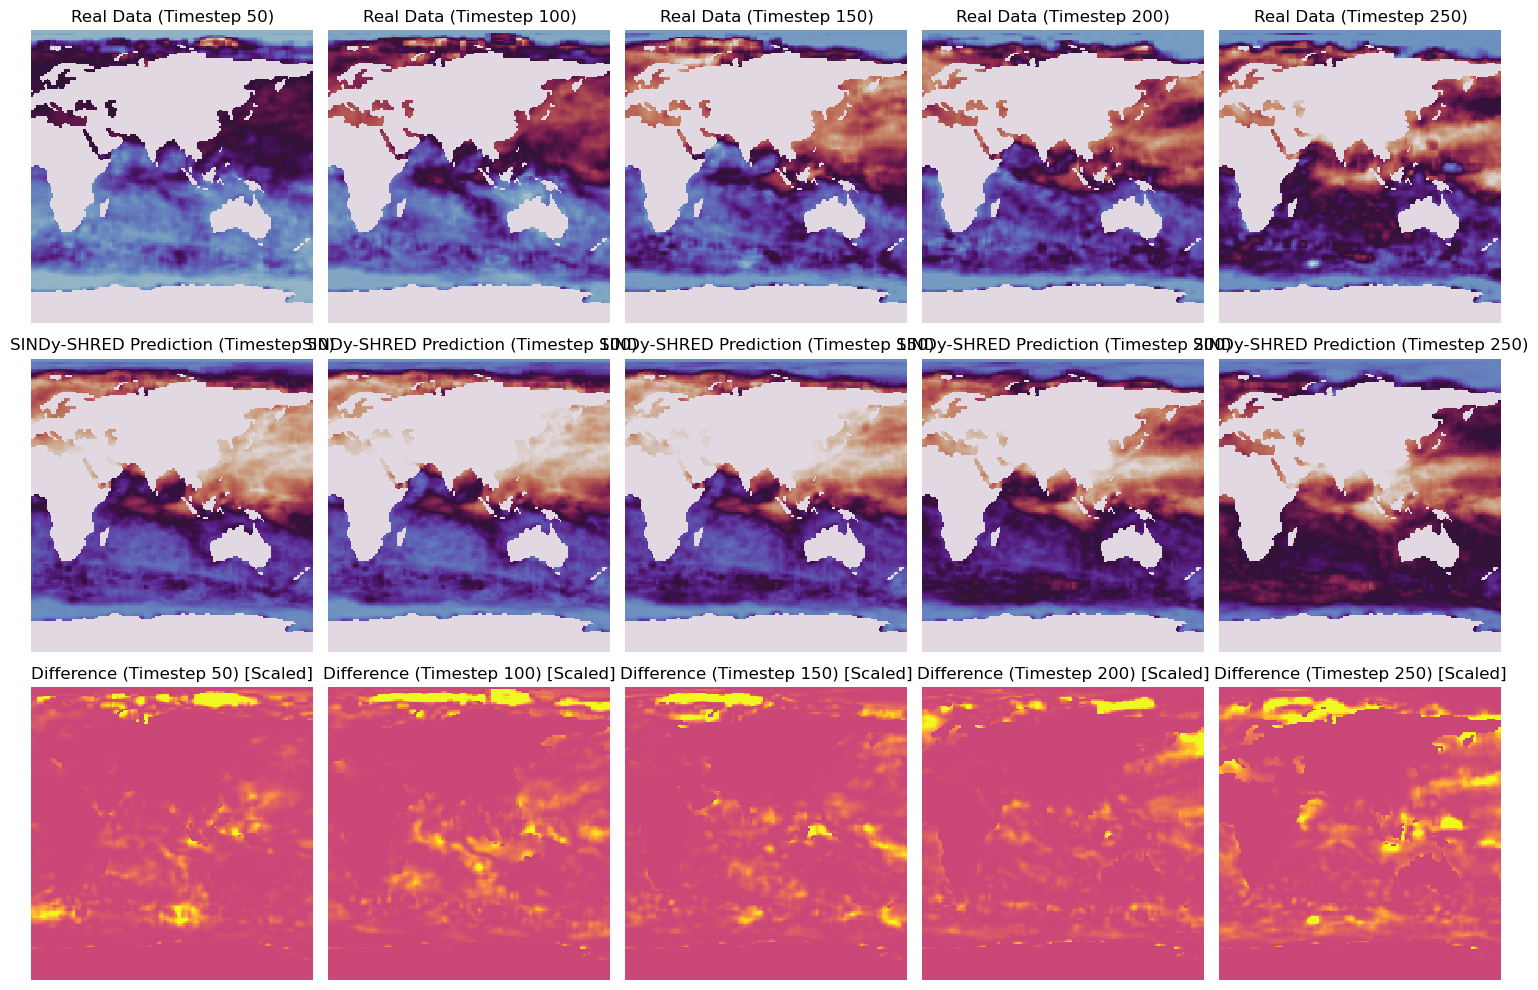

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_zoomed_comparison(real_data, sindy_data, sst_locs, timesteps, lat_range, lon_range, diff_scale=10):
    """
    Plot the real SST data, SINDy-SHRED predictions, and their differences in a specific area (zoomed).
    The difference is amplified by a scaling factor to make it clearer.

    Args:
        real_data (np.array): The ground truth SST data.
        sindy_data (np.array): The SINDy-SHRED reconstructed data.
        sst_locs (np.array): Indices of non-zero SST locations.
        timesteps (list of int): List of timesteps to visualize.
        lat_range (tuple): Latitude range for zoom (e.g., (start_lat, end_lat)).
        lon_range (tuple): Longitude range for zoom (e.g., (start_lon, end_lon)).
        diff_scale (float): Scaling factor for amplifying the difference plot.

    Returns:
        None. Displays the comparison plots.
    """
    num_plots = len(timesteps)
    
    fig, axes = plt.subplots(3, num_plots, figsize=(15, 10))
    
    real_data_inverse_transformed = sc.inverse_transform(real_data)
    sindy_data_inverse_transformed = sc.inverse_transform(sindy_data)
    for i, t in enumerate(timesteps):
        # Plot Real Data
        real_sst = np.zeros((180 * 360))-0.25
        real_sst[sst_locs] = 1*(real_data[t, :])
        reshaped_real_sst = real_sst.reshape(180, 360)
        print("max real sst:", np.max(real_sst))
        
        # Select the region of interest (lat_range, lon_range)
        real_sst_zoomed = reshaped_real_sst[lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        axes[0, i].imshow(real_sst_zoomed, aspect='auto', cmap='twilight', interpolation='none')
        axes[0, i].set_title(f'Real Data (Timestep {t})')
        axes[0, i].set_axis_off()

        # Plot SINDy-SHRED Prediction
        sindy_sst = np.zeros((180 * 360))-0.25
        sindy_sst[sst_locs] = 1*(sindy_data[t, :])
        reshaped_sindy_sst = sindy_sst.reshape(180, 360)
        print("max sindy sst:", np.max(reshaped_sindy_sst))
        
        # Select the region of interest (lat_range, lon_range)
        sindy_sst_zoomed = reshaped_sindy_sst[lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        axes[1, i].imshow(sindy_sst_zoomed, aspect='auto', cmap='twilight', interpolation='none')
        axes[1, i].set_title(f'SINDy-SHRED Prediction (Timestep {t})')
        axes[1, i].set_axis_off()

        # Plot Difference (Real - SINDy) with scaling factor
        diff_sst_zoomed = 10*np.square(real_sst_zoomed - sindy_sst_zoomed)
        axes[2, i].imshow(diff_sst_zoomed, aspect='auto', cmap='plasma', interpolation='none', vmin=-1, vmax=1)  # Blue-White-Red for differences
        axes[2, i].set_title(f'Difference (Timestep {t}) [Scaled]')
        axes[2, i].set_axis_off()
        
        print(np.mean(np.square(real_data_inverse_transformed[t,:]-sindy_data_inverse_transformed[t,:])))

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
timesteps = [50, 100, 150, 200, 250]  # Define the timesteps you want to compare
lat_range = (0, 180)  # Define the latitude range to zoom in (adjust based on your grid)
lon_range = (0, 180)  # Define the longitude range to zoom in (adjust based on your grid)
plot_zoomed_comparison(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sst_locs, timesteps, lat_range, lon_range, diff_scale=10)


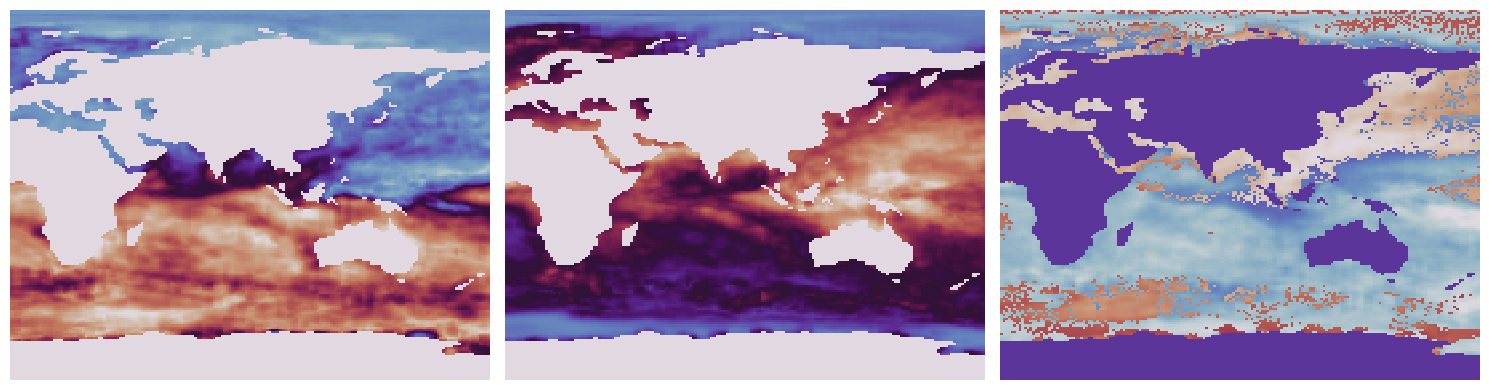

In [20]:
def plot_rescaled_latent_reconstructions(decoder_model, sst_data_path, gru_outs_numpy):
    """
    Rescales and plots the decoder reconstruction for specific latent space vectors (1,0,0), (0,1,0), and (0,0,1).
    Keeps consistent numerical scales and visualization styles.

    Args:
        decoder_model (nn.Module): The decoder model for reconstruction.
        sst_data_path (str): Path to the SST data file.
        gru_outs_numpy (np.array): Original latent space data for Min-Max scaling reversal.

    Returns:
        None. Displays the plots.
    """
    # Define the specific latent space vectors
    latent_vectors = np.eye(3)  # (1,0,0), (0,1,0), (0,0,1)
    # Convert latent vectors to a torch tensor
    latent_vectors_tensor = torch.FloatTensor(latent_vectors).cuda()
    
    for i in range(3):  # Assuming 3 latent dimensions
        latent_vectors_tensor[:, i] = latent_vectors_tensor[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Perform reconstruction using the decoder
    output_reconstructed = decoder_model.linear1(latent_vectors_tensor)
    output_reconstructed = decoder_model.dropout(output_reconstructed)
    output_reconstructed = torch.nn.functional.relu(output_reconstructed)
    output_reconstructed = decoder_model.linear2(output_reconstructed)
    output_reconstructed = decoder_model.dropout(output_reconstructed)
    output_reconstructed = torch.nn.functional.relu(output_reconstructed)
    output_reconstructed = decoder_model.linear3(output_reconstructed)

    # Convert reconstructed data back to numpy
    output_reconstructed_np = output_reconstructed.detach().cpu().numpy()
    
    # Load the SST data to determine grid locations
    load_X = loadmat(sst_data_path)['Z'].T
    mean_X = np.mean(load_X, axis=0)
    sst_locs = np.where(mean_X != 0)[0]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot each reconstructed result
    for i, vec in enumerate(latent_vectors):
        # Initialize an empty array for the entire SST grid
        reconstructed_sst = np.zeros_like(load_X[0, :]) - 0.25

        # Fill the SST grid with the reconstructed values
        reconstructed_sst[sst_locs] = output_reconstructed_np[i, :]

        # Reshape the SST data to 2D (180, 360)
        reshaped_sst = reconstructed_sst.reshape(180, 360)
        
        reshaped_sst = reshaped_sst[lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        axes[i].imshow(reshaped_sst, aspect='auto', cmap='twilight', interpolation='none')
        axes[i].set_axis_off()

    plt.tight_layout()
    plt.show()

plot_rescaled_latent_reconstructions(
    decoder_model=shred,
    sst_data_path='Data/SST_data.mat',
    gru_outs_numpy=gru_outs_numpy
)


max real sst: 1.7433627843856812
max sindy sst: 0.9729624390602112
0.3900746
max real sst: 1.6083333492279053
max sindy sst: 1.0292099714279175
0.58269715
max real sst: 1.3044496774673462
max sindy sst: 0.9733139872550964
0.57529294


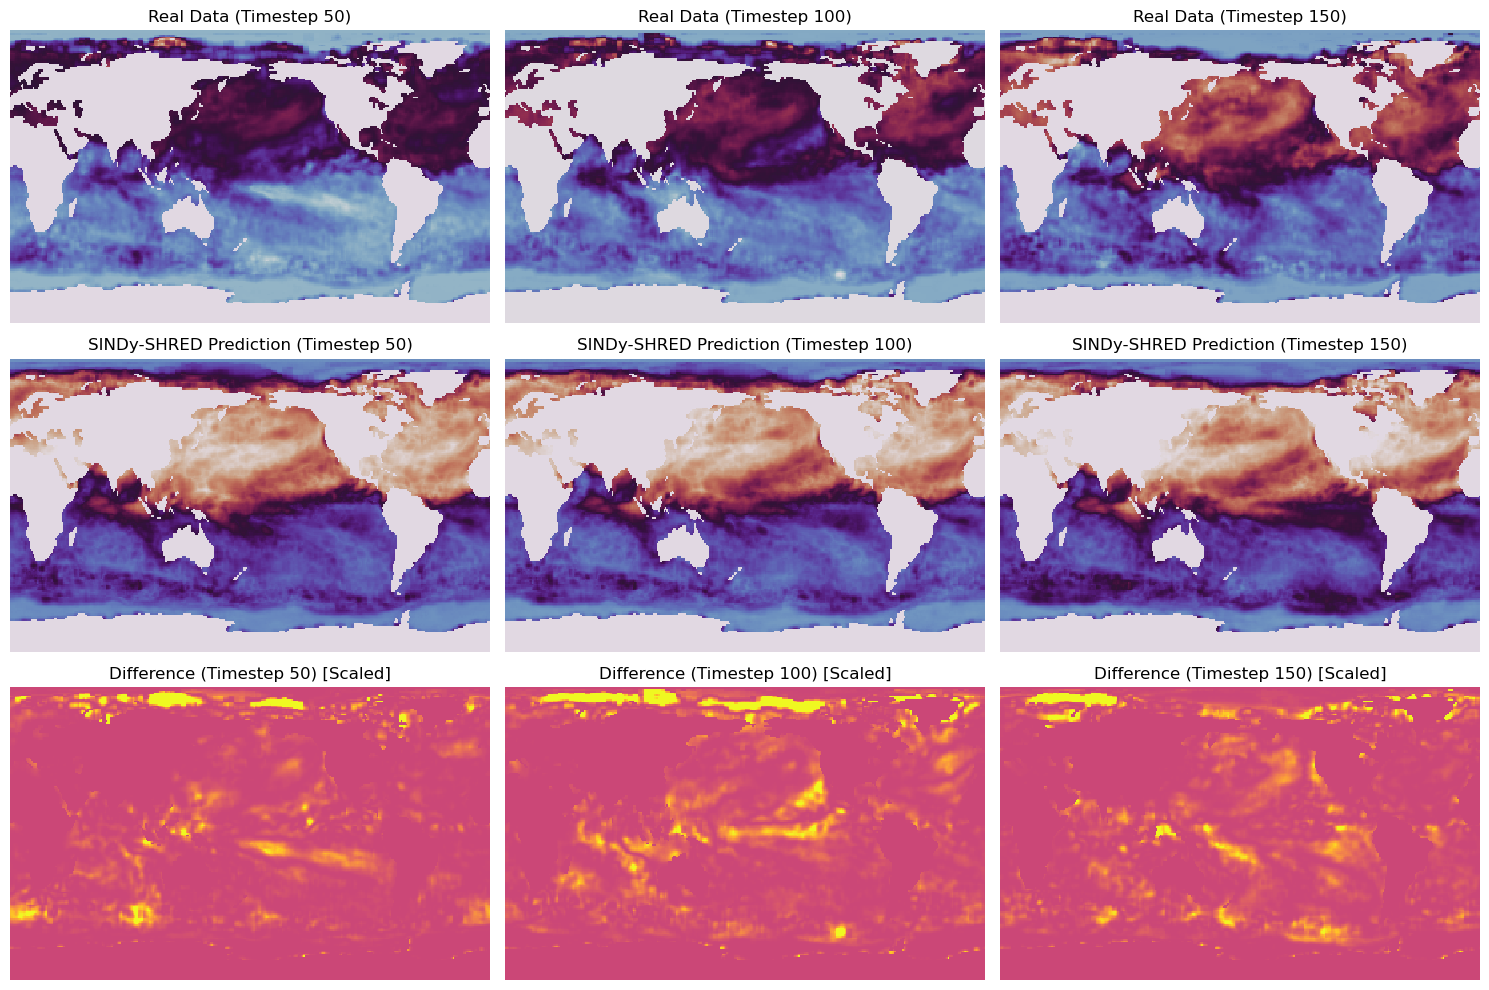

In [21]:
# Example usage:
timesteps = [50, 100, 150]  # Define the timesteps you want to compare
lat_range = (0, 180)  # Define the latitude range to zoom in (adjust based on your grid)
lon_range = (0, 360)  # Define the longitude range to zoom in (adjust based on your grid)
plot_zoomed_comparison(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sst_locs, timesteps, lat_range, lon_range, diff_scale=10)

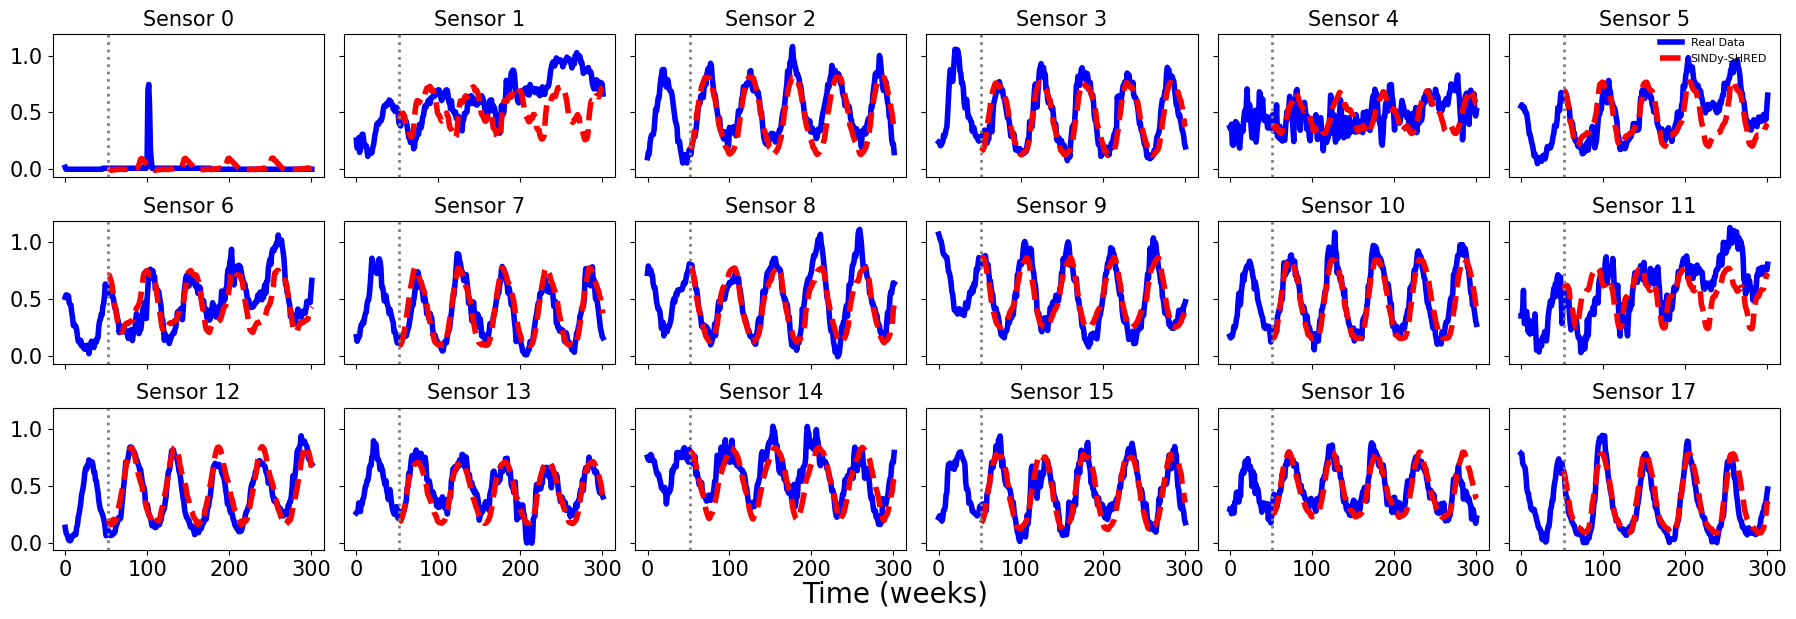

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_sensor_predictions(real_data, sindy_data, sensor_locations, sensor_indices, num_train=52, num_pred=250, rows=4, cols=4):
    """
    Plot the real data and SINDy-SHRED prediction for multiple sensors in a grid layout.
    
    Args:
        real_data (np.array): The real SST data.
        sindy_data (np.array): The predicted data from SINDy-SHRED.
        sensor_locations (np.array): Sensor locations (indices) used in training.
        sensor_indices (list): Indices of the sensors to visualize.
        num_train (int): Number of training data points (default is 100).
        num_pred (int): Number of prediction data points (default is 100).
        rows (int): Number of rows in the grid layout.
        cols (int): Number of columns in the grid layout.
    
    Returns:
        None. Displays and saves the plot.
    """
    num_sensors = len(sensor_indices)
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2*rows), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing
    
    for i, sensor_idx in enumerate(sensor_indices):
        if i >= rows * cols:
            break  # Stop if we've exceeded the number of subplots
        
        sensor = sensor_locations[sensor_idx]
        
        # Real data for the training period
        sensor_real_data = real_data[:num_train+num_pred, sensor]
        
        # SINDy-SHRED prediction for the prediction period
        sensor_pred_data = sindy_data[num_train:num_train+num_pred, sensor]
        
        axes[i].plot(np.arange(num_train+num_pred), sensor_real_data, color="blue", linewidth=4)
        axes[i].plot(np.arange(num_train, num_train+num_pred), sensor_pred_data, color="red", linestyle="--", linewidth=4)
        
        axes[i].set_title(f'Sensor {sensor_idx}', fontsize=15)
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        
        # Add a vertical line to separate training and prediction periods
        axes[i].axvline(x=num_train, color='gray', linestyle=':', linewidth=2)
        
    # Remove any unused subplots
    for i in range(num_sensors, rows * cols):
        fig.delaxes(axes[i])
    
    # Add labels and title
    fig.text(0.5, 0.0, 'Time (weeks)', ha='center', va='center', fontsize=20)
#     fig.text(0.02, 0.5, 'Sensor Value', ha='center', va='center', rotation='vertical', fontsize=10)
#     fig.suptitle("Real Data (blue) vs SINDy-SHRED Prediction (red dashed)", fontsize=14)
    
    # Add a common legend
    lines = [plt.Line2D([0], [0], color="blue", lw=4),
             plt.Line2D([0], [0], color="red", linestyle="--", lw=4)]
    labels = ["Real Data", "SINDy-SHRED"]
    fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.99, 0.945), fontsize=8, frameon=False)
    
    plt.tight_layout()
    plt.savefig('sensor_predictions_grid.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
sensor_locations_test = np.random.randint(1, 40000, size=18)
sensor_indices = list(range(0, 18, 1))  # Choose 32 sensors (0, 5, 10, ..., 155)
plot_multiple_sensor_predictions(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sensor_locations_test, sensor_indices, rows=3, cols=6)